In [1]:
# Install necessary dependencies

!pip install -r requirements.txt

In [1]:
# Import necessary libraries
import pandas as pd
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from kafka import KafkaProducer, KafkaConsumer
import json
import time
import re
from nltk.tokenize import word_tokenize

In [2]:
# Download necessary NLTK data if not already
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hieu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hieu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# DATA COLLECTION AND PREPROCESSING

In [3]:
# Preprocess text function

def preprocess_text(text):
    # Remove URLs using regex
    text = re.sub(r'http\S+', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    return tokens

In [4]:
# Load Facebook comments csv dataset
df = pd.read_csv('fb_sentiment.csv')
df.head()
data = [(row['FBPost'], row['Label']) for _, row in df.iterrows()]

# Preprocess the data
processed_data = [(preprocess_text(text), label) for text, label in data]

# Split data into training and testing sets
train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=42)

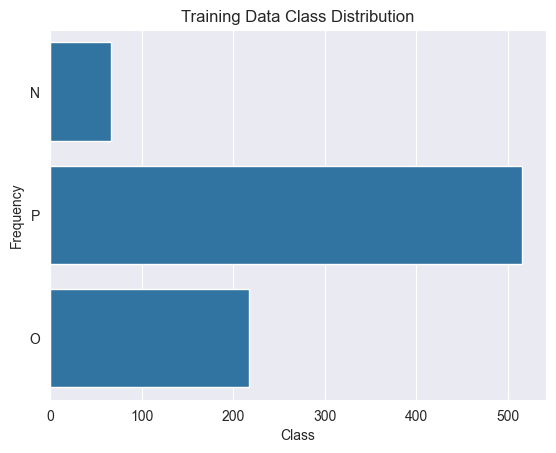

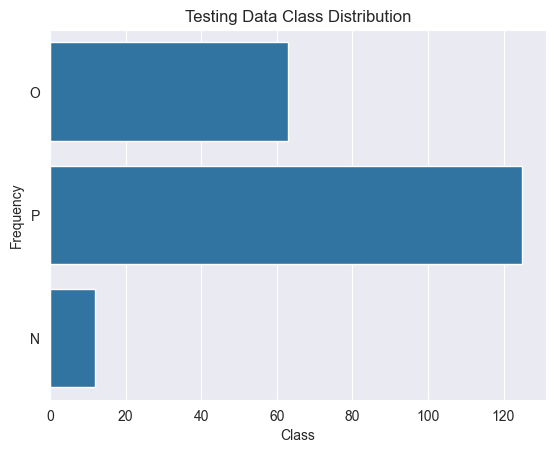

In [5]:
# Explore data distribution
def plot_class_distribution(docs, title):
    labels = [label for (_, label) in docs]
    sns.countplot(labels)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()
    
plot_class_distribution(train_data, 'Training Data Class Distribution')
plot_class_distribution(test_data, 'Testing Data Class Distribution')

In [6]:
# Initialize SentimentAnalyzer
sentiment_analyzer = SentimentAnalyzer()

In [7]:
# Extract words with negation handling
all_words_neg = sentiment_analyzer.all_words([mark_negation(words) for words, label in train_data])
unigram_feats = sentiment_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentiment_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [8]:
# Apply features to obtain a feature-value representation of datasets
training_set = sentiment_analyzer.apply_features(train_data)
test_set = sentiment_analyzer.apply_features(test_data)

In [9]:
# Train Naive Bayes classifier
trainer = NaiveBayesClassifier.train
classifier = sentiment_analyzer.train(trainer, training_set)

Training classifier


# Kafka - Producer for Sending Comments

In [10]:
def create_producer():
    return KafkaProducer(
        bootstrap_servers='localhost:9092',
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

def send_comment(producer, topic, comment):
    producer.send(topic, {'comment': comment})
    producer.flush()

# Kafka - Consumer for Processing Comments

In [11]:
def create_consumer():
    return KafkaConsumer(
        'comments',
        bootstrap_servers='localhost:9092',
        value_deserializer=lambda v: json.loads(v.decode('utf-8'))
    )

def create_result_producer():
    return KafkaProducer(
        bootstrap_servers='localhost:9092',
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

# CLASSIFY COMMENTS 

In [12]:
def classify_comment(comment, classifier, sentim_analyzer):
    tokens = preprocess_text(comment)
    neg_tokens = mark_negation(tokens)
    features = sentim_analyzer.apply_features([(neg_tokens, '')])
    prediction = classifier.classify(features[0][0])
    return prediction

consumer = create_consumer()
result_producer = create_result_producer()

In [13]:
# Process incoming comments
def process_comments():
    for message in consumer:
        comment = message.value['comment']
        prediction = classify_comment(comment, classifier, sentiment_analyzer)
        if prediction == 'neg':
            result_producer.send('negative_comments', {'comment': comment})
        else:
            result_producer.send('positive_comments', {'comment': comment})
        result_producer.flush()

In [14]:
# Send comments to Kafka
def send_comments_from_csv(producer, topic, df):
    for index, row in df.iterrows():
        comment = row['FBPost']
        send_comment(producer, topic, comment)

In [ ]:
# Orchestrate the analysis in main function
if __name__ == "__main__":
    producer = create_producer()
    send_comments_from_csv(producer, 'comments', df)
    process_comments()